# Case: Model Operationalization
### Part 1a: Training a model in the development environment

Welcome to the first part of the case! In this step we will train the model which we will later deploy into our production environment. 
The goal of this step is to get a feeling for the data and the model that were dealing with. 
As in many data science departments, you will use Jupyter notebook to train the model. 
Using Jupyter Notebook enables us to make our script readable and easily explainable to others, because of the options to include visualizations and text blocks.

Run the code and have a quick look to understand what is going on. The whole notebook should run without problem already. Check out the code and try to figure out which pickle files you have to make. Don't spend too much time on  understanding the details of the code!

Good luck and have fun!

In [27]:
# Imports

import pandas as pd
import random
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# We set a random seed to get the same results with every run
random.seed(15) 

In [28]:
import pickle
def save(file_name, data):
    with open(file_name, 'wb') as f:pickle.dump(data, f)

Our dataset contains HR data - for each employee we have collected data and we mark if he had left the company or not.
We would like to train a model to alert us on potential employees who might leave us.

In [29]:
# Put the csv file in the same directory as this notebook or update the path below
csv_path = "HR_source_data.csv"

In [30]:
inputdata = pd.read_csv(r"{}".format(csv_path), header=0, sep=",")
inputdata.sample(5)

,Employee number,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spent_company,Work_accident,left,promotion_last_5years,department,salary
948,948,0.61,0.86,4,196,4,0,1,0,hr,low
1029,1029,0.10,0.82,6,272,4,0,1,0,technical,low
10042,10042,0.94,0.67,3,142,3,0,0,0,technical,medium
10933,10933,0.58,0.97,3,274,4,1,0,1,sales,medium
3129,3129,0.99,0.67,5,153,2,0,0,0,RandD,low


In [31]:
# Let's review some statistics

inputdata.describe()

,Employee number,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spent_company,Work_accident,left,promotion_last_5years
count,13880.000000,13557.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000
mean,6939.500000,0.620645,0.716246,3.802954,200.816066,3.450000,0.149135,0.200504,0.019524
std,4006.955203,0.245240,0.169864,1.196040,49.287490,1.432269,0.356235,0.400392,0.138364
min,0.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,3469.750000,0.450000,0.560000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,6939.500000,0.650000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,10409.250000,0.820000,0.870000,5.000000,244.000000,4.000000,0.000000,0.000000,0.000000
max,13879.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [32]:
# We will use specific variables for the model

columns = ['average_monthly_hours', 'department', 'salary', 'number_project', 'last_evaluation', 'satisfaction_level', 'left']
inputdata = inputdata.loc[:, columns]
inputdata.sample(5)

,average_monthly_hours,department,salary,number_project,last_evaluation,satisfaction_level,left
3777,231,technical,medium,4,0.94,0.90,0
8168,218,sales,low,3,0.82,0.80,0
8762,137,management,medium,5,0.67,0.91,0
6599,133,technical,medium,5,0.62,0.99,0
8157,188,product_mng,medium,2,0.60,0.42,0


In [33]:
save('pickle_objects/columns.pkl', columns)

department
IT             0.192612
RandD          0.131682
accounting     0.219101
hr             0.236152
management     0.129730
marketing      0.201274
product_mng    0.189320
sales          0.207871
support        0.207792
technical      0.211848
Name: left, dtype: float64


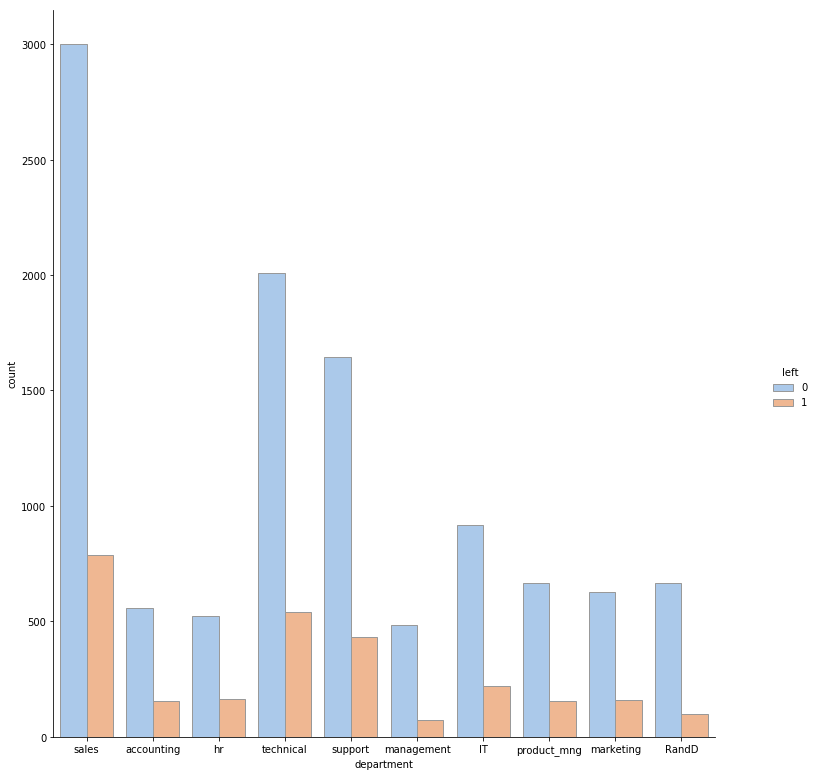

In [34]:
# Does department affects churn? And what about other columns?
# Plot categories histogram and split with explained variable
g=sns.catplot(x="department", hue="left", kind="count",
            palette="pastel", edgecolor=".6",
            data=inputdata)
g.fig.set_size_inches(12, 12)

# And as a table - average churn rate per department
print(inputdata.groupby('department').mean()['left'])

# Churn is lower in RandD and managment

## In order to build a model, the following transformations on the data will have to be applied:
1. Dummify categorical variables
2. Create a new variable 
3. Scale and Impute certain variables

In [35]:
# Split to train and test
train_img, test_img = train_test_split(inputdata, test_size=0.3, random_state=15)

In [36]:
# Alter department variables based on exploration
train_img['department'] = train_img['department'].apply(lambda x: 'other' if x not in ['RandD','management'] else x)

# Dummify the department variable  
train_img = pd.concat([train_img, pd.get_dummies(train_img['department'])], axis=1)
train_img.drop('department', axis=1, inplace=True)
train_img.sample(5)

,average_monthly_hours,salary,number_project,last_evaluation,satisfaction_level,left,RandD,management,other
2727,140,medium,6,0.56,0.15,0,0,0,1
330,140,low,2,0.57,0.38,1,0,0,1
1121,147,medium,2,0.47,0.38,1,0,0,1
5351,271,low,3,0.97,0.76,0,0,0,1
7909,247,medium,3,0.51,0.81,0,0,0,1


In [37]:
# Make salary an ordinal variable

replace_map_salary = {'salary': {'low': 1, 'medium': 2, 'high': 3}}
train_img.replace(replace_map_salary, inplace=True)
train_img.sample(5)

,average_monthly_hours,salary,number_project,last_evaluation,satisfaction_level,left,RandD,management,other
2913,139,2,3,0.74,0.84,0,0,0,1
7654,205,2,5,0.50,0.81,0,0,0,1
3444,176,1,5,0.75,0.96,0,0,0,1
11077,150,2,4,0.57,0.97,0,0,0,1
11378,138,1,3,0.53,0.68,0,0,0,1


In [38]:

save('pickle_objects/replace_map_salary.pkl', columns)

In [39]:
# Create new variable - number of hours per project

train_img['hours_per_project'] = train_img['average_monthly_hours']/train_img['number_project']
train_img.sample(5)

,average_monthly_hours,salary,number_project,last_evaluation,satisfaction_level,left,RandD,management,other,hours_per_project
4202,194,2,4,0.65,0.13,0,0,0,1,48.50
13234,220,2,4,0.82,0.79,0,0,0,1,55.00
5627,267,2,4,0.86,NaN,0,0,0,1,66.75
5190,141,3,5,0.74,0.21,0,0,0,1,28.20
6721,135,1,5,0.81,0.66,0,0,1,0,27.00


In [49]:
# Scale the average monthly hours variable using the min-max scaler

scaler = sklearn.preprocessing.MinMaxScaler()
train_img['average_monthly_hours'] = scaler.fit_transform(train_img['average_monthly_hours'].values.reshape(-1, 1))
train_img.sample(5)

,average_monthly_hours,salary,number_project,last_evaluation,satisfaction_level,left,RandD,management,other,hours_per_project
7302,0.686916,2,5,0.68,0.59,0,0,0,1,48.6
13288,0.252336,2,4,0.57,0.97,0,0,0,1,37.5
13498,0.182243,2,5,0.41,0.97,0,0,0,1,27.0
11394,0.817757,3,5,0.79,0.14,0,0,1,0,54.2
13224,0.476636,2,4,0.80,0.51,0,0,0,1,49.5


In [50]:
print(scaler)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [51]:
save("scaler.pkl", scaler)

In [42]:
# Dealing with missing values
# Impute satisfaction level using the mean of the variable

train_img.satisfaction_level.fillna(train_img.satisfaction_level.mean(), inplace=True)
train_img.describe()

,average_monthly_hours,salary,number_project,last_evaluation,satisfaction_level,left,RandD,management,other,hours_per_project
count,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000
mean,0.490870,1.599321,3.811033,0.716059,0.619291,0.200803,0.052491,0.040140,0.907369,56.856670
std,0.230901,0.633200,1.199033,0.169803,0.242445,0.400621,0.223026,0.196298,0.289929,19.199956
min,0.000000,1.000000,2.000000,0.360000,0.090000,0.000000,0.000000,0.000000,0.000000,16.166667
25%,0.285047,1.000000,3.000000,0.560000,0.460000,0.000000,0.000000,0.000000,1.000000,43.400000
50%,0.485981,2.000000,4.000000,0.720000,0.640000,0.000000,0.000000,0.000000,1.000000,53.666667
75%,0.696262,2.000000,5.000000,0.870000,0.810000,0.000000,0.000000,0.000000,1.000000,67.750000
max,1.000000,3.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,148.000000


In [43]:
satisfaction_level_mean = train_img.satisfaction_level.mean()
save("pickle_objects/satisfaction_level_mean.pkl", satisfaction_level_mean)

In [44]:
# Let's use Random Forest for classficiation
# More hyperparameters can be tweaked, but we keep it simple for now --> not the focus of this module

forest = RandomForestClassifier(n_estimators=100, n_jobs=1)

In [45]:
X_train = train_img.drop(['left'], axis=1)
y_train = train_img.loc[:, 'left']

forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [46]:
save("forest.pkl", forest)

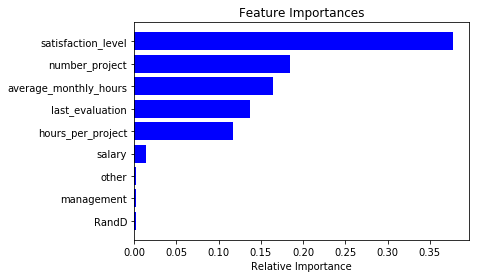

In [23]:
# Using feature importance, we can better understand which variables are contributing to the model the most

features = X_train.columns
importances = forest.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [48]:
save("features.pkl", features)

print(features)

Index(['average_monthly_hours', 'salary', 'number_project', 'last_evaluation',
       'satisfaction_level', 'RandD', 'management', 'other',
       'hours_per_project'],
      dtype='object')


In [67]:
# Create a pipeline to transform the test set to the version we can use for model training.
# In other words, apply the same transformations as we have done during our exploration phase, but now in one function.
def test_transformation(test_set):
    # Create a local copy of the incoming data in this function.
    test_set_copy = test_set.copy()
    
    # Transform department variable
    test_set_copy['department'] = test_set_copy['department'].apply(lambda x: 'other' if x not in ['RandD', 'management'] else x)
    
    # Dummify categorical variable 
    test_set_copy = pd.concat([test_set_copy, pd.get_dummies(test_set_copy['department'])], axis=1)
    
    # Remove old categorical variable 
    test_set_copy.drop('department', axis=1, inplace=True)
    
    # Make salary variable ordinal
    test_set_copy.replace(replace_map_salary, inplace=True)
    
    # Create new variable
    test_set_copy['hours_per_project'] = test_set_copy['average_monthly_hours'] / test_set_copy['number_project']
    
    # Scale  average monthly hours
    test_set_copy['average_monthly_hours'] = scaler.transform(test_set_copy['average_monthly_hours'].values.reshape(-1,1))
    
    # Impute missing values in satisfaction level
    test_set_copy.satisfaction_level.fillna(train_img.satisfaction_level.mean(), inplace=True)
    
    return test_set_copy.drop(['left'], axis=1),test_set_copy.loc[:, 'left']

X_test, y_test = test_transformation(test_img)

In [68]:
expected = y_test

# Make new predictions
predicted = forest.predict(X_test)

# Create confusion matrix
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3332
           1       0.93      0.92      0.93       832

    accuracy                           0.97      4164
   macro avg       0.96      0.95      0.95      4164
weighted avg       0.97      0.97      0.97      4164



## Exercise: save relevant model objects to be able to deploy the model to production

In [69]:
# Tip - Go through the theory to recall which model objects are relevant to save.
# Use the pickle package documentation to save the model objects

In [70]:
# save the model, the mean, the column names, scaling parameters and the salary encoder

In [ ]:
# forest, columns, scaler, impute function, encoder

In [71]:
# Imports
import pandas as pd
import random
import warnings
import sklearn
import pickle
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

# We set a random seed to get the same results with every run
random.seed(15)

# Put your path to the CSV file here
csv_path = 'HR_new_recruitment.csv'

# We just received new data from HR.
df = pd.read_csv(r'{}'.format(csv_path), header=0, sep=',')
print(df.describe())


       satisfaction_level  time_spent_company  number_project  \
count          734.000000         1119.000000     1119.000000   
mean             0.534428            4.096515        3.804290   
std              0.268260            1.657524        1.619464   
min              0.090000            2.000000        2.000000   
25%              0.370000            3.000000        2.000000   
50%              0.500000            4.000000        4.000000   
75%              0.780000            5.000000        5.000000   
max              0.990000           10.000000        7.000000   

       average_monthly_hours  Work_accident  promotion_last_5years  
count            1119.000000    1119.000000            1119.000000  
mean              212.633601       0.088472               0.042895  
std               298.931038       0.284107               0.202712  
min                98.000000       0.000000               0.000000  
25%               148.000000       0.000000               0.000000  
